# Recommending a restaurant location in Northern Suburbs of Melbourne

## 1. Introduction

### This code implementation determines the ideal location for an Indian restaurant in Northern suburbs of Melbourne by performining data analysis after webscraping, cleaning and performing data visualisation.

Finding a suitable location for food business in a metropolitan city like Melbourne can be challenging. Looking at the variety and number of Indian restaurants in the city, it is vital that aspects such as location, cuisine and parking are considered carefully.

Data that might be contributing to determining the best recommendations for a restaurant is based on the number of restaurants in the area, type of restaurants and venues. This project aims to suggest the most suitable location for opening a restaurant in Melbourne Northern suburbs.
Restaurant owners and partners would be undoubtedly interested in finding the apt site for opening their restaurant in Melbourne.

In [1]:
#imports....
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
!pip install geopy
!pip install pgeocode
import pgeocode
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
! pip install folium==0.5.0
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

###### source of webscraping

In [2]:
URL = "https://postcodes-australia.com/state-postcodes/vic"
page = requests.get(URL)
soup = BeautifulSoup(page.content,'html.parser')

Below is the code for webscrapping. As the html was list with 'li' and 'ul' tags, the below code finds all the 'li' tags and reads the data into a list accordingly. Cleaning the data by striping new line characters is performed to the list. Finally, the list is converted to a Data Frame.

In [3]:
sublist = []
viclist = soup.find_all(class_ = "pclist")
i=0
for sub in viclist:
    temp = {}
    ulList = sub.find_all('li')
    #print(ulList)
    for li in ulList:
        alist = li.find_all('a')
        for a in alist:
            
            if a == None or a.text == 'Back to top of page' or a.text == 'Return to home page':
                pass
            else:
                x = int(a.text)
                ul = li.find_all('ul')
                for l in ul:
                    if l == None:
                        pass
                    else:
                        temp = {}
                        if ((x > 3000) and (x < 3100)):
                            temp['Place'] = l.text.strip('\n').split('\n')[0]
                            temp['Postcode'] = a.text
                       # print(temp)
                            sublist.append(temp)
df = pd.DataFrame(sublist)
df.shape

(89, 2)

Below is the code to get latitudes and longitudes of the suburb locations. These details are appended to the df dataframe and are required to get venue details from Foursquare

In [4]:
pgeocode.Nominatim('au')
geolocator = pgeocode.Nominatim('au')
postal_codes = df['Postcode'].tolist() #to list
latitudes = []
longitudes = []
for i, postal_code in enumerate(postal_codes):
    g = geolocator.query_postal_code(postal_code)
    if not g.empty:
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)

df['Latitude'] = latitudes
df['Longitude'] = longitudes

#drop any Nan values from latitude and longitude
df = df.dropna(subset=['Latitude'])
df = df.dropna(subset=['Longitude'])


df.head()


,Place,Postcode,Latitude,Longitude
0,Melbourne,3001,-37.8140,144.9633
1,East Melbourne,3002,-37.8133,144.9839
2,West Melbourne,3003,-37.8088,144.9473
3,Melbourne,3004,-37.8140,144.9676
4,World Trade Centre,3005,-37.8152,144.9632


In [5]:
address = 'Melbourne'

geolocator = Nominatim(user_agent="au_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Melbourne are -37.8142176, 144.9631608.


###### Map displaying all the data points on Melbourne.

In [6]:
map_melb = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Place']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melb)  
    
map_melb

##### Foursquare client id, client secret and version details to generate the URL 

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [8]:
df.loc[0, 'Place']

'Melbourne'

In [9]:
neighborhood_latitude = df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Place'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Melbourne are -37.814, 144.9633.


In [10]:
LIMIT=100
radius=2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId=4d4b7105d754a06374d81259&categoryId!=4bf58dd8d48988d10f941735&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

The url is ready. Note that the categoryId is used in the url, which helps determining the food businesses in the given vicinity

In [11]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The following code will pass the url to the requests and call the API to get venue details close to the latitude and longitude. 

In [ ]:
venues = requests.get(url).json()['response']['groups'][0]['items']
nearby_venues =[]
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply([get_category_type], axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

Following is the function to get the venue details

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId=4d4b7105d754a06374d81259&categoryId!=4bf58dd8d48988d10f941735&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Pass the Place and location details to the above function to get melbourne venues

In [17]:
melb_venues = getNearbyVenues(names=df['Place'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Melbourne
East Melbourne
West Melbourne
Melbourne
World Trade Centre
Southbank
Docklands
University Of Melbourne
Footscray
Brooklyn
Yarraville
Newport
Williamstown
Altona
Braybrook
Albion
Albanvale
Ardeer
Burnside
Mambourin
Altona North
Laverton North
Laverton Raaf
Altona Meadows
Hoppers Crossing
Chartwell
Flemington
Ascot Vale
Keilor East
Avondale Heights
Keilor
Calder Park
Keilor Downs
Moonee Ponds
Aberfeldie
Essendon North
Airport West
Gladstone Park
Pascoe Vale
Melbourne Airport
Glenroy
Broadmeadows
Coolaroo
Attwood
Royal Melbourne Hospital
North Melbourne
Parkville
Carlton
Carlton North
Brunswick West
Brunswick
Brunswick East
Coburg
Greenvale
Fawkner
Campbellfield
Somerton
Oaklands Junction
Craigieburn
Fitzroy
Collingwood
Abbotsford
Clifton Hill
Northcote
Thornbury
Preston
Reservoir
Thomastown
Lalor
Epping
Alphington
Ivanhoe
Bellfield
Mill Park
Bundoora
Eaglemont
Macleod
La Trobe University
Watsonia
Briar Hill
Diamond Creek
Plenty
Yarrambat
Lower Plenty
Montmorency
Eltham
Wattle G

Number of venues in each location

In [18]:
melb_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abbotsford,12,12,12,12,12,12
Aberfeldie,5,5,5,5,5,5
Airport West,3,3,3,3,3,3
Albanvale,1,1,1,1,1,1
Albion,5,5,5,5,5,5
...,...,...,...,...,...,...
West Melbourne,27,27,27,27,27,27
Williamstown,5,5,5,5,5,5
World Trade Centre,100,100,100,100,100,100


In [17]:
print('There are {} uniques categories.'.format(len(melb_venues['Venue Category'].unique())))

There are 82 uniques categories.


Below is the statistical analysis of the data. It shows the food venues based on the cuisine in that location

In [20]:
melb_onehot = pd.get_dummies(melb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
melb_onehot['Neighborhood'] = melb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [melb_onehot.columns[-1]] + list(melb_onehot.columns[:-1])
melb_onehot = melb_onehot[fixed_columns]

melb_onehot

,Neighborhood,Afghan Restaurant,African Restaurant,Argentinian Restaurant,Armenian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yunnan Restaurant
0,Melbourne,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Melbourne,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Melbourne,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Melbourne,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Melbourne,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,Eltham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
949,Eltham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
950,Eltham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951,Eltham,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group rows by neighborhood and by taking the mean of the frequency of the occurances

In [21]:
melb_grouped = melb_onehot.groupby('Neighborhood').mean().reset_index()
melb_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,Argentinian Restaurant,Armenian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yunnan Restaurant
0,Abbotsford,0.0,0.0,0.00,0.0,0.083333,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.083333,0.000000,0.0
1,Aberfeldie,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.20,0.0,0.000000,0.000000,0.0
2,Airport West,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0
3,Albanvale,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,1.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0
4,Albion,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,West Melbourne,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,0.037037,0.0
61,Williamstown,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.20,0.0,0.000000,0.000000,0.0
62,World Trade Centre,0.0,0.0,0.01,0.0,0.020000,0.01,0.0,0.01,0.01,...,0.02,0.0,0.05,0.0,0.02,0.02,0.0,0.010000,0.020000,0.0
63,Yarrambat,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0


For each neighborhood, get the top 5 venues with highest frequency

In [22]:
num_top_venues = 5

for hood in melb_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = melb_grouped[melb_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbotsford----
                           venue  freq
0                           Café  0.50
1            Japanese Restaurant  0.08
2  Vegetarian / Vegan Restaurant  0.08
3               Asian Restaurant  0.08
4             Italian Restaurant  0.08


----Aberfeldie----
               venue  freq
0               Café   0.4
1    Thai Restaurant   0.2
2             Bakery   0.2
3         Food Court   0.2
4  Afghan Restaurant   0.0


----Airport West----
                       venue  freq
0         Italian Restaurant  0.33
1          Fish & Chips Shop  0.33
2                     Bakery  0.33
3  Middle Eastern Restaurant  0.00
4           Ramen Restaurant  0.00


----Albanvale----
                       venue  freq
0                  BBQ Joint   1.0
1          Afghan Restaurant   0.0
2  Middle Eastern Restaurant   0.0
3                 Restaurant   0.0
4           Ramen Restaurant   0.0


----Albion----
                venue  freq
0  Chinese Restaurant   0.2
1         Pizza Place   0.2


Below is the method to get the most common venues to the locations

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets create a new dataframe with 10 most common venues to each location using the above method

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = melb_grouped['Neighborhood']

for ind in np.arange(melb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(melb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbotsford,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Italian Restaurant,Asian Restaurant,Japanese Restaurant,Burger Joint,Yunnan Restaurant,Fast Food Restaurant,Donut Shop
1,Aberfeldie,Café,Bakery,Thai Restaurant,Food Court,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
2,Airport West,Bakery,Italian Restaurant,Fish & Chips Shop,Food,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
3,Albanvale,BBQ Joint,Yunnan Restaurant,Food,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
4,Albion,Chinese Restaurant,Gastropub,Pizza Place,Café,Bakery,Yunnan Restaurant,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
60,West Melbourne,Café,Pizza Place,Sandwich Place,Italian Restaurant,Food Truck,Bakery,Noodle House,Mexican Restaurant,Bistro,Himalayan Restaurant
61,Williamstown,Food,Fast Food Restaurant,Pizza Place,Thai Restaurant,Italian Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
62,World Trade Centre,Café,Italian Restaurant,Korean Restaurant,Mexican Restaurant,Sushi Restaurant,Japanese Restaurant,Sandwich Place,Dumpling Restaurant,Burger Joint,Bakery
63,Yarrambat,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant


##### Machine learning using K Means algorithm

K means algorithm is most common unsupervising learning methodology

In [28]:
kclusters = 6

melb_grouped_clustering = melb_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(melb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 0, 0, 3, 0, 0, 4, 1], dtype=int32)

k value is later determined by the Elbow method. 

The K-Elbow Visualizer implements the “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters

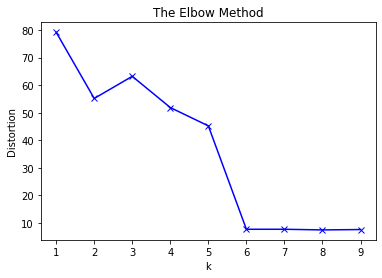

In [33]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(melb_grouped_clustering)
    distortions.append(sum(np.min(cdist(melb_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / melb_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

The above graph shows that the optimal k value for clustering is 6

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

melb_merged = df

Joining the dataframes and replacing neighborhoods to Place

In [ ]:
melb_merged = melb_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Place')

Drop all the Nans from the table

In [27]:
melb_merged=melb_merged.dropna(axis=0,inplace=False)

melb_merged

,Place,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Melbourne,3001,-37.8140,144.963300,0.0,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
1,East Melbourne,3002,-37.8133,144.983900,0.0,Café,Australian Restaurant,Sushi Restaurant,Restaurant,Pizza Place,Indian Restaurant,Italian Restaurant,Fish & Chips Shop,Falafel Restaurant,Diner
2,West Melbourne,3003,-37.8088,144.947300,0.0,Café,Pizza Place,Sandwich Place,Italian Restaurant,Food Truck,Bakery,Noodle House,Mexican Restaurant,Bistro,Himalayan Restaurant
3,Melbourne,3004,-37.8140,144.967600,0.0,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
4,World Trade Centre,3005,-37.8152,144.963200,0.0,Café,Italian Restaurant,Korean Restaurant,Mexican Restaurant,Sushi Restaurant,Japanese Restaurant,Sandwich Place,Dumpling Restaurant,Burger Joint,Bakery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Diamond Creek,3089,-37.6728,145.153700,0.0,Café,Fish & Chips Shop,Malay Restaurant,Fast Food Restaurant,Yunnan Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
82,Yarrambat,3091,-37.6390,145.133400,3.0,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
84,Montmorency,3094,-37.7188,145.124500,0.0,Café,Chinese Restaurant,Thai Restaurant,Burger Joint,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
85,Eltham,3095,-37.7043,145.158267,0.0,Café,Pizza Place,Australian Restaurant,Yunnan Restaurant,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant


Creates the new dataframe that includes the cluster

In [28]:
count_venue = melb_merged
count_venue = count_venue.drop(['Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,BBQ Joint,Bakery,Café,Chinese Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Truck,Gastropub,Italian Restaurant,Middle Eastern Restaurant,Pizza Place,Polish Restaurant,Restaurant,South Indian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,1,1,22,1,1,2,0,1,0,4,0,0,1,0,1,0,1
1,0,0,0,0,0,1,0,0,1,0,1,4,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


##### Code to generate a Bar chart

Text(0, 0.5, 'Clusters')

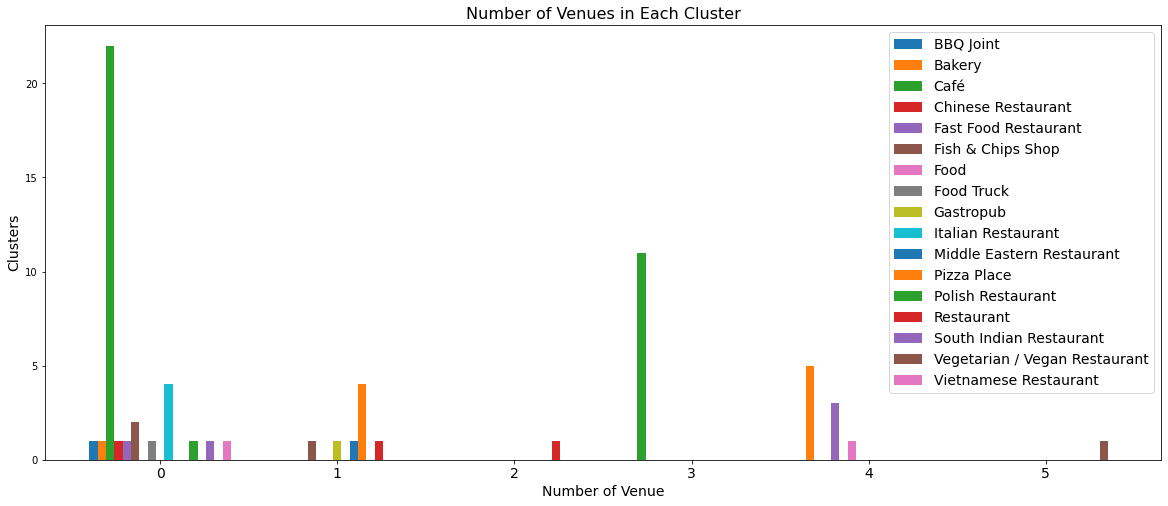

In [29]:
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

From the above Bar chart we can assign names to the cluster.
cluster 0 = Cafes
cluster 1 = Bakery and so on

Below is the code to generate map clusters on the melbourne map

In [30]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(melb_merged['Latitude'], melb_merged['Longitude'], melb_merged['Place'], melb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Below is for list of venues of each cluster

In [31]:
melb_merged.loc[melb_merged['Cluster Labels'] == 0, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3001,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
1,3002,Café,Australian Restaurant,Sushi Restaurant,Restaurant,Pizza Place,Indian Restaurant,Italian Restaurant,Fish & Chips Shop,Falafel Restaurant,Diner
2,3003,Café,Pizza Place,Sandwich Place,Italian Restaurant,Food Truck,Bakery,Noodle House,Mexican Restaurant,Bistro,Himalayan Restaurant
3,3004,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
4,3005,Café,Italian Restaurant,Korean Restaurant,Mexican Restaurant,Sushi Restaurant,Japanese Restaurant,Sandwich Place,Dumpling Restaurant,Burger Joint,Bakery
5,3006,Café,Asian Restaurant,Restaurant,Burger Joint,Fast Food Restaurant,Sandwich Place,Caucasian Restaurant,Mexican Restaurant,Paella Restaurant,Pizza Place
6,3008,Café,Restaurant,Italian Restaurant,Chinese Restaurant,Pizza Place,Seafood Restaurant,Sandwich Place,Middle Eastern Restaurant,Steakhouse,Australian Restaurant
8,3011,Vietnamese Restaurant,Café,Asian Restaurant,Pizza Place,Malay Restaurant,Portuguese Restaurant,Restaurant,Chinese Restaurant,Burger Joint,Fast Food Restaurant
9,3012,Food Truck,Breakfast Spot,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
13,3018,Café,Pizza Place,Diner,Thai Restaurant,Italian Restaurant,Snack Place,Yunnan Restaurant,Falafel Restaurant,Doner Restaurant,Donut Shop


In [32]:
melb_merged.loc[melb_merged['Cluster Labels'] == 1, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,3015,Restaurant,Malay Restaurant,Indian Restaurant,Pizza Place,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
26,3031,Pizza Place,Fast Food Restaurant,Café,Yunnan Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
27,3032,Pizza Place,Café,Middle Eastern Restaurant,Yunnan Restaurant,Fast Food Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
29,3034,Pizza Place,Bakery,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
37,3043,Fish & Chips Shop,Pizza Place,Deli / Bodega,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
42,3048,Middle Eastern Restaurant,Bakery,Pizza Place,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
77,3086,Pizza Place,Café,Yunnan Restaurant,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
78,3087,Gastropub,Pizza Place,Yunnan Restaurant,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant


In [33]:
melb_merged.loc[melb_merged['Cluster Labels'] == 2, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,3049,Restaurant,Yunnan Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant


In [34]:
melb_merged.loc[melb_merged['Cluster Labels'] == 3, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,3010,Café,Japanese Restaurant,Pizza Place,Chinese Restaurant,Indian Restaurant,Food Truck,Sushi Restaurant,Food Court,Middle Eastern Restaurant,Mexican Restaurant
38,3044,Café,Snack Place,Yunnan Restaurant,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
44,3050,Café,Thai Restaurant,Japanese Restaurant,Food Court,Mexican Restaurant,Bistro,Malay Restaurant,Yunnan Restaurant,Fast Food Restaurant,Doner Restaurant
45,3051,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
62,3068,Café,Pizza Place,Yunnan Restaurant,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
65,3072,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
70,3078,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
71,3079,Café,Restaurant,Yunnan Restaurant,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
74,3083,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
82,3091,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant


In [35]:
melb_merged.loc[melb_merged['Cluster Labels'] == 4, melb_merged.columns[[1] + list(range(5, melb_merged.shape[1]))]]

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,3013,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Malay Restaurant,Yunnan Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
12,3016,Food,Fast Food Restaurant,Pizza Place,Thai Restaurant,Italian Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
14,3019,Bakery,Fast Food Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,German Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
18,3023,Fast Food Restaurant,Bakery,Noodle House,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
20,3025,Fast Food Restaurant,Sandwich Place,Yunnan Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
36,3042,Bakery,Italian Restaurant,Fish & Chips Shop,Food,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
39,3045,Bakery,Café,Fast Food Restaurant,Food,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fish & Chips Shop
46,3052,Bakery,Fast Food Restaurant,BBQ Joint,Food,Food Court,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
68,3075,Bakery,Food,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop


To read tabled from a pdf file, which shows the list of suburbs with most Indians. This is important to determine the ideal location 

In [36]:
pip install tabula-py

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


Convert the pdf table to csv file

In [37]:
import tabula
 
file = "https://www.multicultural.vic.gov.au/images/2016_Census/CommunityProfiles2016/India-Community-Profile-2016-Census.pdf"
 
tabula.convert_into(file, "iris_all.csv", pages = 10)
poplist = pd.read_csv("iris_all.csv")

Got stderr: Apr 10, 2021 3:00:52 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr 10, 2021 3:00:52 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr 10, 2021 3:00:53 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr 10, 2021 3:00:53 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



Convert the list into a dataframe and clean it removing unwanted columns

In [38]:
popdf = pd.DataFrame(poplist)
popdf.drop("Rank.1", axis=1, inplace=True)
popdf.drop("Unnamed: 2", axis=1, inplace=True)
popdf

,Rank,Unnamed: 3
0,in 2016,"Suburbs with most India-born, ranked"
1,1,"Tarneit, Point Cook, Truganina, Hoppers Crossi..."
2,2,"Hampton Park, Cranbourne East, Berwick, Narre ..."
3,3,"Noble Park, Dandenong, Springvale (Vic.), Keys..."
4,4,"Epping (Vic.), Wollert, South Morang, Lalor, T..."
5,5,"Glen Waverley, Clayton, Mount Waverley, Mulgra..."
6,6,"St Albans (Vic.), Sydenham (Vic.), Deer Park, ..."
7,7,"Craigieburn, Roxburgh Park, Broadmeadows (Vic...."
8,8,"Carnegie, Glen Huntly, Bentleigh East, Ormond,..."
9,9,"Melbourne, Docklands, Southbank, Carlton (Vic...."


In [39]:
poplist = (popdf['Unnamed: 3'].str.replace(" ","")).str.split(",")
poplist[2]

['HamptonPark',
 'CranbourneEast',
 'Berwick',
 'NarreWarrenSouth',
 'CranbourneNorth']

As it can be seen from the above table that every suburb had multiple locations. Therefore, seperate the list into single location for each row

In [40]:
dfpop = pd.DataFrame(poplist[1])
dfpop = dfpop.append(pd.DataFrame(poplist[2]),ignore_index=True)
dfpop = dfpop.append(pd.DataFrame(poplist[3]),ignore_index=True)
dfpop = dfpop.append(pd.DataFrame(poplist[4]),ignore_index=True)
dfpop = dfpop.append(pd.DataFrame(poplist[5]),ignore_index=True)
dfpop = dfpop.append(pd.DataFrame(poplist[6]),ignore_index=True)
dfpop = dfpop.append(pd.DataFrame(poplist[7]),ignore_index=True)
dfpop = dfpop.append(pd.DataFrame(poplist[8]),ignore_index=True)
dfpop = dfpop.append(pd.DataFrame(poplist[9]),ignore_index=True)
dfpop.columns=['Place']
dfpop

,Place
0,Tarneit
1,PointCook
2,Truganina
3,HoppersCrossing
4,WyndhamVale
5,HamptonPark
6,CranbourneEast
7,Berwick
8,NarreWarrenSouth
9,CranbourneNorth


Performing data cleaning by removing extra spaces and (Vic) to make the further comparison easy

In [41]:
dfpop=(dfpop.replace("\(Vic.\)",'',regex=True).astype(str))
dfpop['Place'].str.strip()
melb_merged['Place'].str.strip()
melb_merged=melb_merged.reset_index()
melb_merged
#dfpop

,index,Place,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Melbourne,3001,-37.8140,144.963300,0.0,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
1,1,East Melbourne,3002,-37.8133,144.983900,0.0,Café,Australian Restaurant,Sushi Restaurant,Restaurant,Pizza Place,Indian Restaurant,Italian Restaurant,Fish & Chips Shop,Falafel Restaurant,Diner
2,2,West Melbourne,3003,-37.8088,144.947300,0.0,Café,Pizza Place,Sandwich Place,Italian Restaurant,Food Truck,Bakery,Noodle House,Mexican Restaurant,Bistro,Himalayan Restaurant
3,3,Melbourne,3004,-37.8140,144.967600,0.0,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
4,4,World Trade Centre,3005,-37.8152,144.963200,0.0,Café,Italian Restaurant,Korean Restaurant,Mexican Restaurant,Sushi Restaurant,Japanese Restaurant,Sandwich Place,Dumpling Restaurant,Burger Joint,Bakery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,80,Diamond Creek,3089,-37.6728,145.153700,0.0,Café,Fish & Chips Shop,Malay Restaurant,Fast Food Restaurant,Yunnan Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
62,82,Yarrambat,3091,-37.6390,145.133400,3.0,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant
63,84,Montmorency,3094,-37.7188,145.124500,0.0,Café,Chinese Restaurant,Thai Restaurant,Burger Joint,Fast Food Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant
64,85,Eltham,3095,-37.7043,145.158267,0.0,Café,Pizza Place,Australian Restaurant,Yunnan Restaurant,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant


Comparing the two data frames based on the location

In [42]:
mergedStuff = pd.merge(dfpop,melb_merged, left_on='Place',right_on='Place', how='inner')
mergedStuff


,Place,index,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Epping,69,3076,-37.6307,145.01710,0.0,Italian Restaurant,Café,Yunnan Restaurant,Fish & Chips Shop,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant
1,Lalor,68,3075,-37.6673,145.01450,4.0,Bakery,Food,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Egyptian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
2,Thomastown,67,3074,-37.6821,145.01260,0.0,Fish & Chips Shop,Fried Chicken Joint,Café,Middle Eastern Restaurant,Halal Restaurant,Gastropub,French Restaurant,Food Truck,Food Court,Food
3,Melbourne,0,3001,-37.8140,144.96330,0.0,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
4,Melbourne,3,3004,-37.8140,144.96760,0.0,Café,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant,Burger Joint,Ramen Restaurant,Dumpling Restaurant,Indonesian Restaurant
5,Docklands,6,3008,-37.8183,144.94450,0.0,Café,Restaurant,Italian Restaurant,Chinese Restaurant,Pizza Place,Seafood Restaurant,Sandwich Place,Middle Eastern Restaurant,Steakhouse,Australian Restaurant
6,Southbank,5,3006,-37.8291,144.95305,0.0,Café,Asian Restaurant,Restaurant,Burger Joint,Fast Food Restaurant,Sandwich Place,Caucasian Restaurant,Mexican Restaurant,Paella Restaurant,Pizza Place
7,Carlton,47,3053,-37.8007,144.96710,0.0,Italian Restaurant,Café,Thai Restaurant,Pizza Place,Asian Restaurant,Vegetarian / Vegan Restaurant,Malay Restaurant,Fish & Chips Shop,Burger Joint,Japanese Restaurant


Epping, Lalor and Thomastown are three locations common in both the tables. In these places, the frequency of Indian restaurants is less compared to other restaurants.

The datasets used in this project are sourced from different websites. I used BeautifulSoup to scrape this data. 
Considering the demographic data obtained is from the year 2016, there can be a conflict with the result and current business situation. Therefore, it is vital that we obtain an updated list of locations.
I used the K means algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum k value to 6. 
As there are a smaller number of restaurants compared to the Indian population in these areas, it can be inferred that these locations are the ideal locations to open an Indian restaurant.

#### Conclusion
Businesses that focus on the food industry, therefore, choose the location based on the population density in the area. Moreover, considering the ethnicity of the population in the selected location can have a significant impact on business. 
